In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Load

## obj_fibroblasts

In [2]:
dname <- '../../data/cache/obj_fibroblasts/'
fields_load <- c('meta_data', 'effects_nested', 'effects_marginal')
# fields_load <- c('meta_data', 'umap_after', 'umap_before', 'V', 'V_unweighted', 'effects_nested', 'effects_marginal')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(tissue_cluster = case_when(
        tissue_cluster == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cluster
    ))

# %>% 
#     with(table(tissue_cluster))


In [3]:
masc_res <- readRDS('../../data/cache/confusion_analysis_results.rds')


## adams

In [4]:
adams <- readRDS('../../data/Adams/query.rds')
adams$effects <- readRDS('../../data/Adams/effects.rds')
# adams$masc_res <- readRDS('../../data/Adams/masc_res.rds')
adams$frequencies <- readRDS('../../data/cache/adams_ttest_frequencies.rds')

## travaglini

In [5]:
trav <- readRDS('../../data/Travaglini/obj_mesenchymal')

# Travaglini clusters: heatmap

In [6]:
## Markers from paper
markers_list <- map(
    paste0('Cluster ', 25:33), 
    function(sheetname) {
        openxlsx::read.xlsx('../../data/Travaglini/41586_2020_2922_MOESM6_ESM.xlsx', sheetname, startRow = 2) %>% 
            arrange(-avg_logFC) %>% head(20) %>% 
            subset(avg_logFC >= .5) %>%
            dplyr::select(Gene:p_val_adj)
    }
)

names(markers_list) <- c('ASM', 'VSM', 'MyoF', 'FibM', 'AdvF', 'AlvF', 'LipF', 'Peri', 'Meso')
markers <- bind_rows(markers_list, .id = 'Cluster')

## Make markers unique to a cluster 
markers <- data.table(markers)[, .SD[order(-avg_logFC)][1], by = Gene]

## Matrix of betas 
X <- trav$effects %>% 
    subset(feature %in% Reduce(union, markers)) %>% 
    dplyr::select(SCORE=beta, Cluster, feature) %>% 
    tidyr::spread(Cluster, SCORE, fill = 0) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix()

markers <- subset(markers, Gene %in% rownames(X))

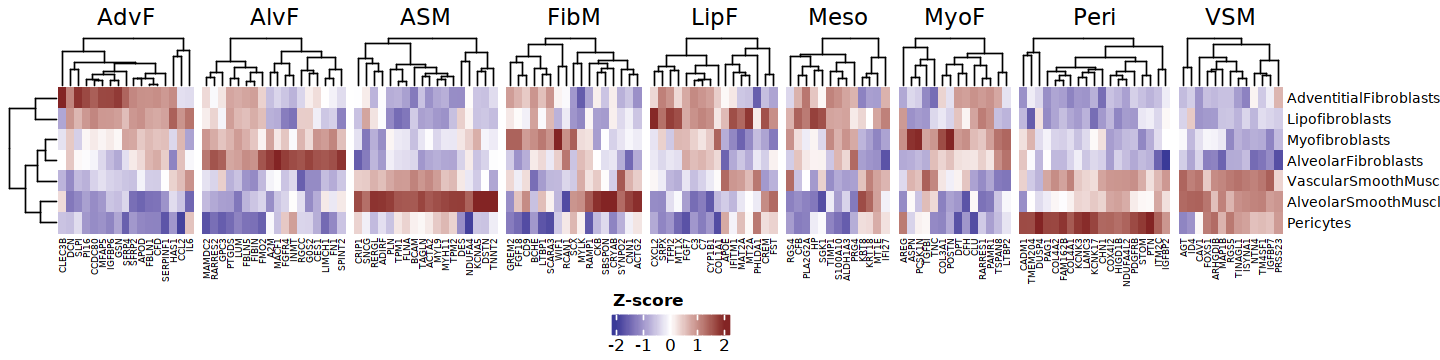

In [7]:
fig.size(3, 12)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 5))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))
suppressWarnings({
    h3 <- split(markers$Gene, markers$Cluster) %>% imap(function(.genes, .cluster) {
        ## ComplexHeatmap requires identical columns
        if (.cluster == 'VSM') {
            Heatmap(
                t(X[.genes, ]) %>% scale(),
    #             t(X[.genes, ]),
                show_column_names = TRUE,
                show_heatmap_legend = TRUE,
                name = 'Z-score',
                column_title = .cluster,
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        } else {
            Heatmap(
                t(X[.genes, ]) %>% scale(),
    #             t(X[.genes, ]),
    #             show_column_names = FALSE,
                show_heatmap_legend = FALSE,
                column_title = .cluster,
                heatmap_legend_param = list(direction = "horizontal"),
                col = colorRamp2(c(-2, 0, 2), c(muted('blue'), "white", muted("red")))
            )
            
        }
    }) %>% 
        purrr::reduce(`+`)
    
})



h3 <- grid.grabExpr(draw(h3, merge_legend = TRUE, heatmap_legend_side = "bottom"))

# h3 <- grid.grabExpr(draw(h3))
p4 <- wrap_elements(full = h3)
p4

# Travaglini clusters: UMAP

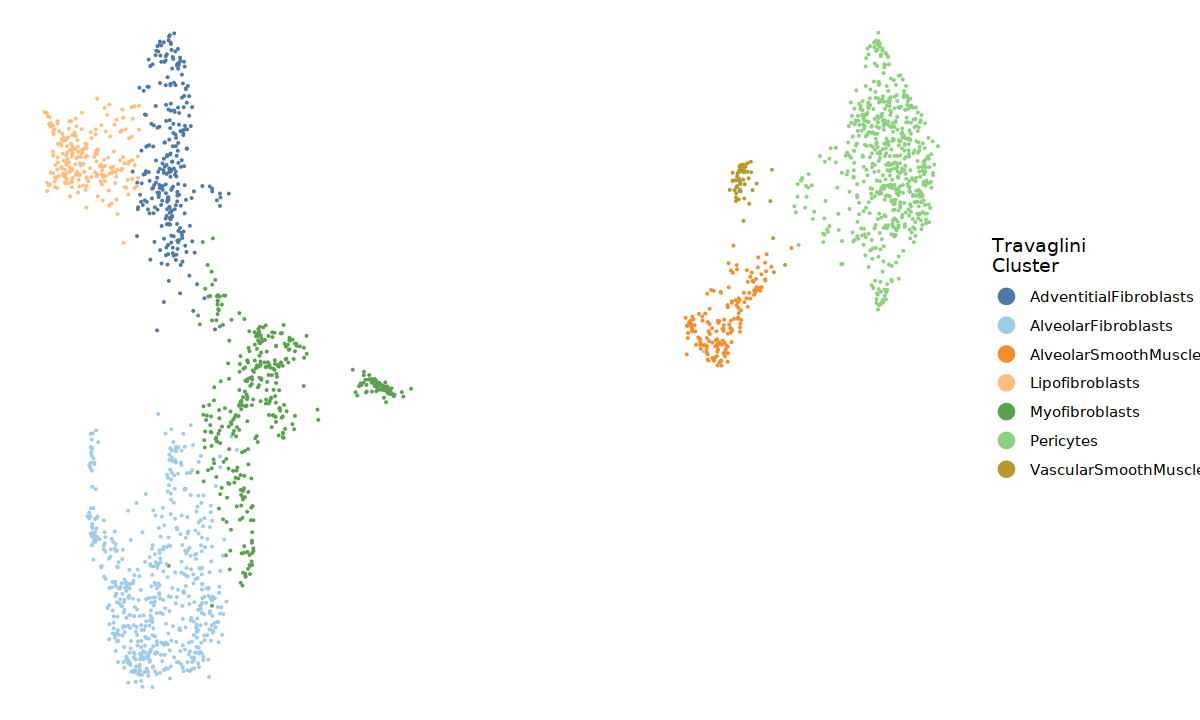

In [8]:
fig.size(6, 10)
idx <- which(!is.na(trav$meta_data$ClusterTrav))
p5 <- do_scatter(
    trav$U$embedding[idx, ], trav$meta_data[idx, ], 'ClusterTrav', 
    pt_shape = 16, #pt_size = 5, 
#     do_labels = TRUE, no_guides = TRUE
    do_labels = FALSE, no_guides = FALSE
) + 
    theme_void() + 
    labs(color = 'Travaglini\nCluster', fill = 'Travaglini\nCluster')

p5

# Travaglini correspondence UMAPs

In [9]:
ref <- readRDS('../../data/stromal_ref_roche.rds')

In [10]:
system.time({
    dname <- '../../data/cache/obj_fibroblasts/'
#     fields_load <- c('R', 'V', 'Z_corr', 'betas', 'meta_data', 'vargenes_means_sds', 'loadings', 'umap_after_fname')
#     fields_load <- c('meta_data', 'exprs_raw', 'umap_after', 'umap_before', 'V', 'Z_corr')
    fields_load <- c('meta_data', 'umap_after')
    atlas <- map(fields_load, function(name) {
        readRDS(file.path(dname, paste0(name, '.rds')))
    })
    names(atlas) <- fields_load    
})


   user  system elapsed 
  0.476   0.004   0.987 

In [11]:
.m <- atlas$umap_after %>% 
    cbind(atlas$meta_data) %>% 
    inner_join(dplyr::select(ref$meta_data, CellID, ClusterTrav)) %>% 
    subset(!ClusterTrav %in% c('Pericytes', 'VascularSmoothMuscle', 'AlveolarSmoothMuscle') & !is.na(ClusterTrav))

Joining, by = "CellID"


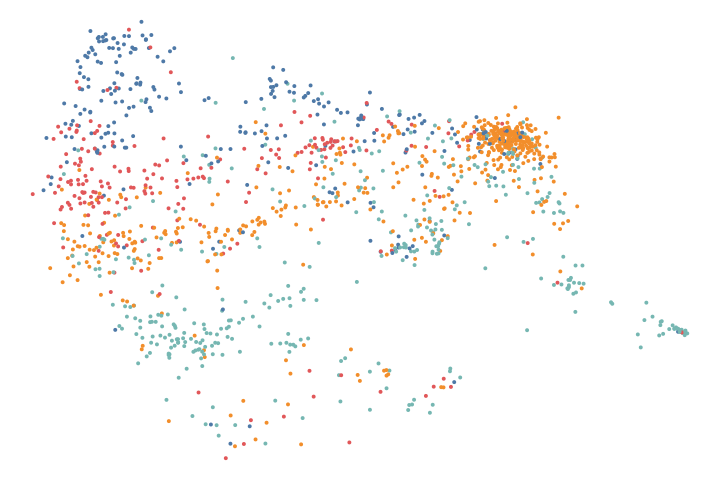

In [12]:
p6 <- do_scatter(
    dplyr::select(.m, `1`, `2`),
    dplyr::select(.m, -`1`, -`2`),
    'ClusterTrav',
    palette_use = tableau_color_pal()(6),
    pt_shape = 16, 
#     do_labels = TRUE, no_guides = TRUE 
    do_labels = FALSE, no_guides = TRUE 
) + 
    theme_void() + 
#     labs(color = 'Travaglini\nCluster', fill = 'Travaglini\nCluster') + 
    NULL

# p7 <- do_scatter(
#     dplyr::select(.m, `1`, `2`),
#     dplyr::select(.m, -`1`, -`2`),
#     'Cluster_name',
#     pt_shape = 16, do_labels = FALSE, no_guides = FALSE 
# ) + 
# labs(fill = 'Cluster Atlas', color = 'Cluster Atlas')

fig.size(4, 6)
# p6 | p7
p6

# Travaglini correspondence Heatmap

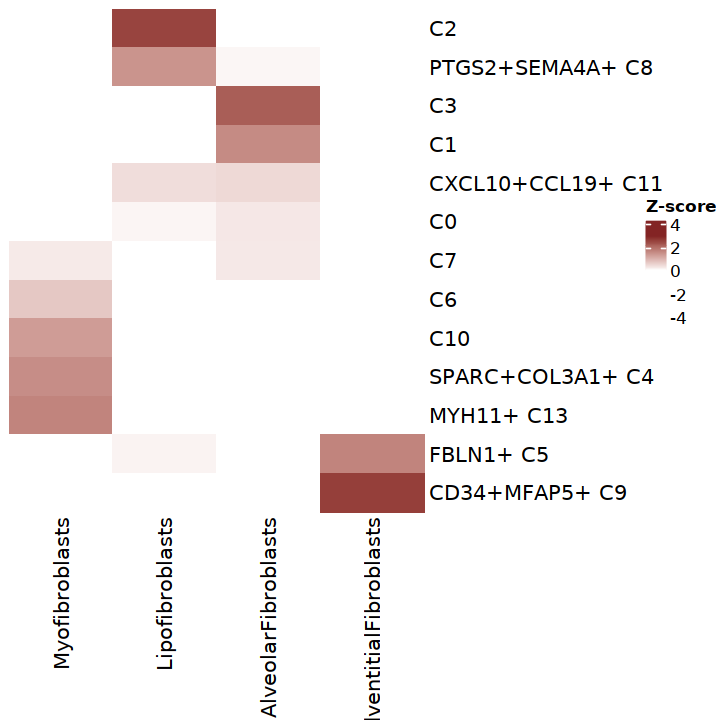

In [13]:
fig.size(6, 6)
ht_opt(RESET = TRUE)
h4 <- .m %>% 
    subset(Cluster != '12') %>% ## Only 5 cells 
    with(table(Cluster_name, ClusterTrav)) %>% 
    prop.table(1) %>% 
    prop.table(2) %>% 
    as('matrix') %>% 
    scale() %>% 
    Heatmap(
        col = colorRamp2(c(-3, 0, 3), c('white', "white", muted("red"))),
        show_column_dend = FALSE,
        name = 'Z-score',
        show_row_dend = FALSE
    )
p7 <- wrap_elements(full = grid.grabExpr(draw(h4)))
p7

# Adams UMAPs

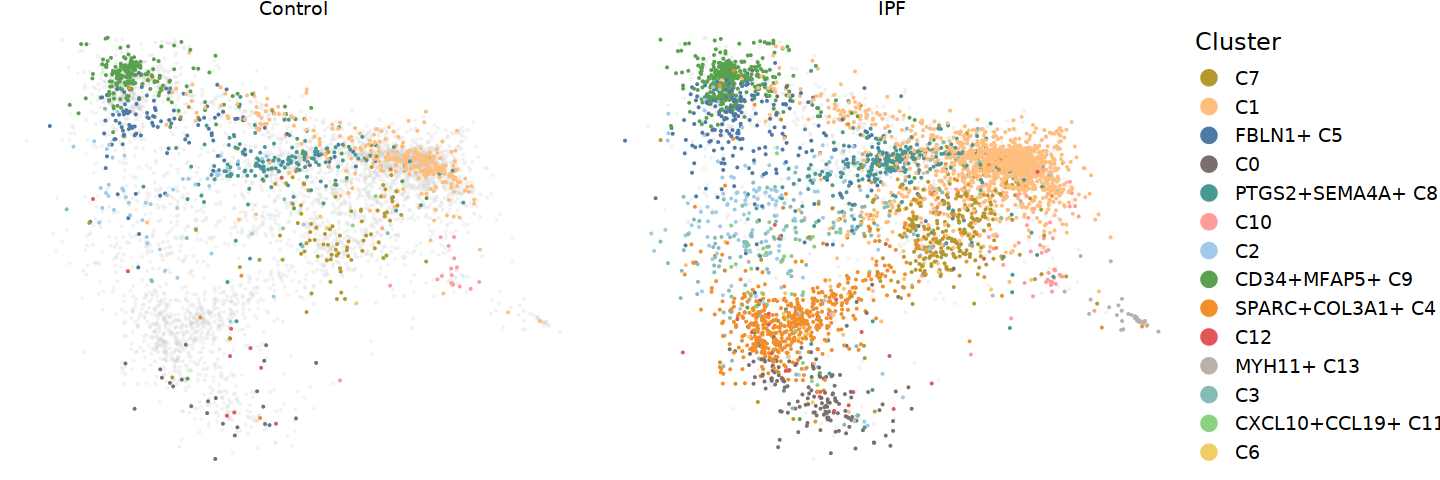

In [14]:
fig.size(4, 12)
p8 <- do_scatter(
#     query$umap, query$meta_data, 'Cluster', 
    adams$umap, adams$meta_data, 'Cluster', 
    quo(Disease_Identity), nrow=1, 
    do_labels=FALSE, no_guides=FALSE, 
    #palette_use=tableau_color_pal('Tableau 20')(14),
    palette_use=palette_global[adams$meta_data$'Cluster'], 
    pt_shape=16, point_size=.5
) + 
    theme_void(base_size = 14) + 
    NULL
p8

# Adams frequency barplot

In [15]:
x1 <- subset(obj$meta_data, Tissue == 'Lung') %>% with(prop.table(table(Cluster_name)))
x2 <- adams$meta_data %>% with(prop.table(table(Cluster)))

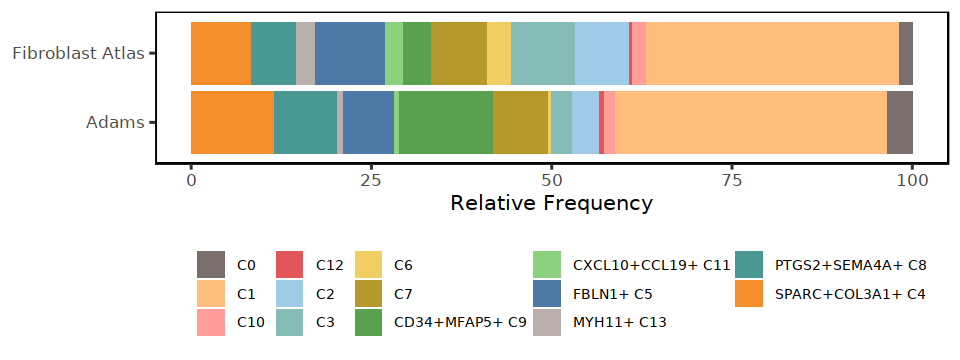

In [16]:
p9 <- tibble(Adams = as.numeric(x2[names(x1)]), `Fibroblast Atlas` = as.numeric(x1), Cluster = names(x1)) %>% 
    tidyr::gather(key, val, -Cluster) %>% 
    ggplot(aes(key, 100*val, fill = Cluster)) + 
        geom_bar(stat = 'identity') + 
        scale_fill_manual(values = palette_global[names(x1)]) + 
        coord_flip() + 
        theme(
            legend.position = 'bottom',
            axis.title.y = element_blank(),
            legend.text = element_text(size = 8),
#             legend.title = element_text(size = 10)
            legend.title = element_blank()
        ) + 
        labs(y = 'Relative Frequency') + 
        NULL
fig.size(3, 8)
p9

# Adams differential frequency plots

In [17]:
prop_df <- data.table(adams$meta_data)[
    , Ntotal := .N, by = .(Subject_Identity)    
][
    , .N, by = .(Cluster, Subject_Identity, Ntotal)
][
    , prop := N / Ntotal
][] %>% 
    dplyr::select(Cluster, Subject_Identity, prop) %>% 
    tidyr::spread(Subject_Identity, prop, fill = 0) %>% 
    tidyr::gather(Subject_Identity, prop, -Cluster) %>% 
    dplyr::left_join(unique(dplyr::select(adams$meta_data, Subject_Identity, Disease_Identity)))

Joining, by = "Subject_Identity"


In [18]:
plt_df <- prop_df %>% 
    subset(grepl('C13|C4|C11', Cluster)) %>% 
#     subset(grepl('C13|C4|C11', Cluster)) %>% 
    left_join(adams$frequencies) %>% 
    dplyr::mutate(LABEL = sprintf('%s\n(fdr=%0.3f)', Cluster, padj)) 
#     dplyr::mutate(Cluster = factor(Cluster, c('SPARC+COL3A1+ C4', 'MYH11+ C13', 'C3', 'CXCL10+CCL19+ C11'))) %>% 
#     dplyr::mutate(LABEL = factor(LABEL, . %>% ) 

plt_levels <- plt_df %>% dplyr::select(LABEL, padj) %>% unique() %>% arrange(padj) %>% with(LABEL)

# p10 <- plt_df %>% 
#     dplyr::mutate(LABEL = factor(LABEL, plt_levels)) %>% 
#     ggplot(aes(Disease_Identity, prop)) + 
#         geom_violin() + 
#         geom_jitter(width = .2, height = 0, shape = 21) + 
#         facet_wrap(~LABEL, scales = 'free_y', nrow=1) 
# #         facet_wrap(~LABEL, scales = 'free_y', ncol=1) 
# fig.size(4, 10)
# # fig.size(6, 3)
# p10

Joining, by = "Cluster"


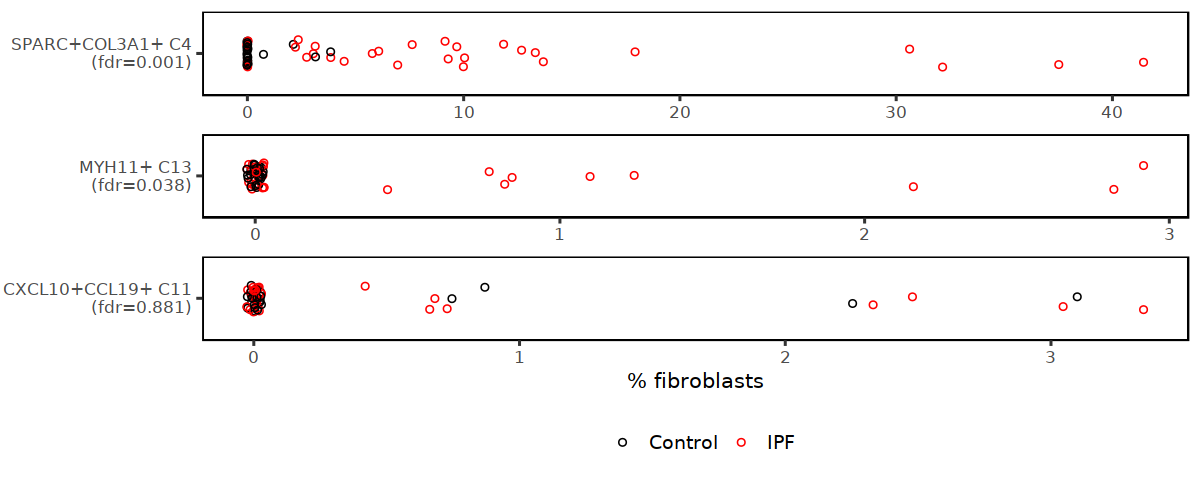

In [19]:
# p10 <- plt_df %>% 
p10 <- data.table(plt_df)[, val := median(100 * prop), by = .(Disease_Identity, LABEL)][] %>% 
    dplyr::mutate(LABEL = factor(LABEL, plt_levels)) %>% 
    ggplot(aes(LABEL, 100 * prop, color = Disease_Identity)) + 
#         geom_violin(position = position_dodge(width = 0), fill = NA) + 
        geom_jitter(width = .2, height = 0.03, shape = 21) + 
#         scale_color_tableau() + 
        scale_color_manual(values = list(Control = 'black', IPF = 'red')) + 
        facet_wrap(~LABEL, scales = 'free', ncol=1) + 
        coord_flip() + 
        theme(
            legend.position = 'bottom',
            strip.text = element_blank(),
            axis.title.y = element_blank()
        ) + 
        labs(y = '% fibroblasts', color = '')
#         facet_wrap(~LABEL, scales = 'free_y', ncol=1) 
fig.size(4, 10)
# fig.size(6, 3)
p10


# Adams heatmap - marker comparison


In [20]:
beta_thresh <- log(2)
plt_df <- inner_join(
     adams$effects %>% 
        dplyr::select(-contrast),
    obj$effects_nested %>% 
        left_join(unique(dplyr::select(obj$meta_data, matches('^Cluster')))) %>% 
        subset(Tissue == 'Lung') %>% 
        dplyr::select(-contrast),
    by = c('feature'), 
    suffix = c('_adams', '_roche')
) 

cor_df <- split(plt_df, plt_df$Cluster_name_adams) %>% imap(function(.SD, .cluster_adams) {
        split(.SD, .SD$Cluster_name_roche) %>% imap(function(.SE, .cluster_roche) {
            .SE %>% 
                dplyr::mutate(LABEL = case_when(
                    (abs(beta_roche) > beta_thresh & abs(zscore_roche) > 1.96) | 
                    (abs(beta_adams) > beta_thresh & abs(zscore_adams) > 1.96) ~ 'yes', 
                    TRUE ~ 'no'
                )) %>% 
                subset(LABEL == 'yes') %>% 
                with(cor.test(~beta_roche + beta_adams)) %>% 
                broom::tidy() %>% 
                cbind(Cluster_roche = .cluster_roche)
        }) %>% 
            bind_rows() %>% 
            cbind(Cluster_adams = .cluster_adams)
    }) %>% 
    bind_rows()


cormat <- cor_df %>% 
    dplyr::select(estimate, matches('^Cluster')) %>% 
    tidyr::spread(Cluster_roche, estimate) %>% 
    tibble::column_to_rownames('Cluster_adams') 

Joining, by = "Cluster"


In [21]:
data.table(cor_df)[, .SD[order(-estimate)][1], by = Cluster_roche] %>% with(quantile(estimate, c(0, 1)))
# %>% with(sd(estimate))
# with(mean(estimate))

0%      100% 
0.3402066 0.8384365

Warning message:
“The input is a data frame, convert it to a matrix.”
Loading required namespace: jpeg



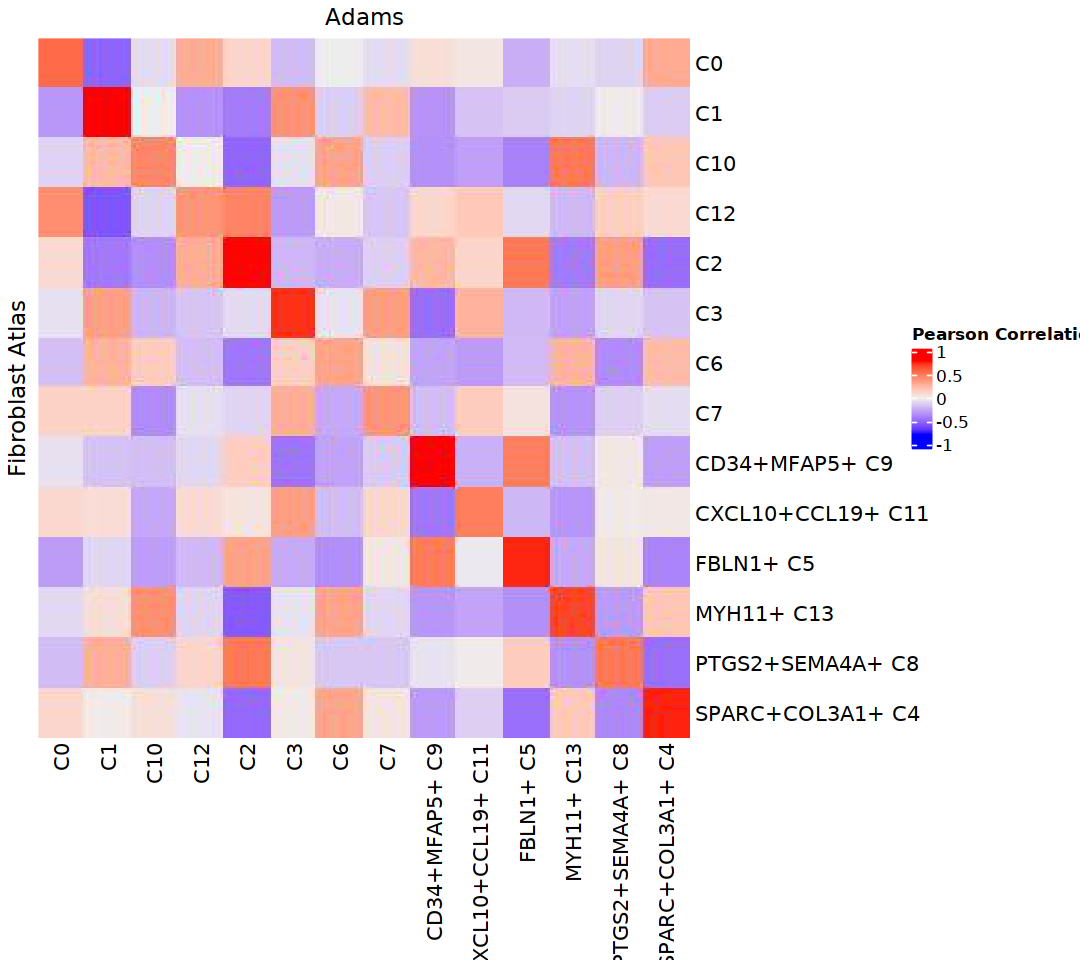

In [22]:
fig.size(8, 9)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 12))

h2 <- Heatmap(
#     .5 * (cormat + t(cormat)), 
    cormat, 
    cluster_rows = FALSE, cluster_columns = FALSE,
    row_title = 'Fibroblast Atlas', column_title = 'Adams',
#     col = colorRamp2(c(-1, 0, 1), c(muted('blue'), "white", muted("red"))),
    use_raster = TRUE, raster_device = "CairoJPEG",
    name = 'Pearson Correlation'
)

p11 <- wrap_elements(full = grid.grabExpr(draw(h2)))

p11


# Adams scatter - C4 and C13 

In [23]:
fig.size(5, 8)
plt_df <- inner_join(
     adams$effects %>% 
        dplyr::select(-contrast),
    subset(obj$effects_nested, Tissue == 'Lung') %>% 
        dplyr::select(-contrast),
    by = c('feature', 'Cluster'), 
    suffix = c('_adams', '_roche')
)

# plt_df <- inner_join(
#     subset(adams$effects, Cluster == '13') %>% 
#         dplyr::select(-contrast),
#     subset(roche, Cluster == '13' & Tissue == 'Lung') %>% 
#         dplyr::select(-contrast),
#     by = c('feature', 'Cluster'), 
#     suffix = c('_adams', '_roche')
# )


head(plt_df)

feature,beta_adams,sigma_adams,zscore_adams,pvalue_adams,Cluster,Cluster_name,Tissue,beta_roche,sigma_roche,zscore_roche,pvalue_roche
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
EXOSC7,2.248549,0.10766579,20.88453,3.701792e-97,9,CD34+MFAP5+ C9,Lung,0.1702971,0.4076026,0.4178017,3.380460e-01
FBN1,1.586084,0.08846326,17.92930,3.482763e-72,9,CD34+MFAP5+ C9,Lung,1.7866047,0.3186163,5.6073857,1.027028e-08
CD248,1.608928,0.09606085,16.74905,2.877029e-63,9,CD34+MFAP5+ C9,Lung,1.9114353,0.3748073,5.0997819,1.700226e-07
MFAP5,3.222465,0.19885843,16.20482,2.331281e-59,9,CD34+MFAP5+ C9,Lung,4.5186842,0.7032796,6.4251600,6.586546e-11
HTRA3,1.948821,0.12027427,16.20314,2.395857e-59,9,CD34+MFAP5+ C9,Lung,2.0662593,0.3307562,6.2470758,2.091041e-10
SEMA3C,1.556558,0.10129553,15.36650,1.373061e-53,9,CD34+MFAP5+ C9,Lung,2.4827112,0.4170903,5.9524555,1.320745e-09


In [24]:
foo <- function(.Cluster, .genes, beta_thresh=log(2)) {
    .x <- plt_df %>% 
        subset(Cluster == .Cluster) %>%
        dplyr::mutate(LABEL = case_when(
            (abs(beta_roche) > beta_thresh & abs(zscore_roche) > 1.96) | 
            (abs(beta_adams) > beta_thresh & abs(zscore_adams) > 1.96) ~ 'yes', 
            TRUE ~ 'no'
        )) 
    cor_res <- broom::tidy(cor.test(~beta_roche + beta_adams, subset(.x, LABEL=='yes')))
    ggplot(.x, aes(beta_adams, beta_roche)) + 
        geom_smooth(
            method = 'lm', data = . %>% subset(LABEL == 'yes'),
            color = muted('blue'), se = FALSE
        ) + 
        geom_point(data = . %>% subset(LABEL == 'yes'), alpha = .5, color = muted('blue')) + 
        geom_point(data = . %>% subset(LABEL == 'no'), alpha = .2, shape = '.') + 
        geom_abline(linetype = 2) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point(
            data = . %>% subset(feature %in% .genes),
            color = muted('red'), shape = 16, size = 2
        ) + 
        geom_label_repel(box.padding = 1,
            data = . %>% subset(feature %in% .genes),
            aes(label = feature), color = muted('red')
        ) + 
        geom_errorbar(
            data = . %>% subset(feature %in% .genes),
            aes(ymin = beta_roche - 2*sigma_roche, ymax = beta_roche + 2*sigma_roche),
            width = 0, color = muted('red')
        ) + 
        geom_errorbarh(
            data = . %>% subset(feature %in% .genes),
            aes(xmin = beta_adams - 2*sigma_adams, xmax = beta_adams + 2*sigma_adams),
            height = 0, color = muted('red')
        ) + 
            labs(
                x = 'logFC (Adams et al)', y = 'logFC (Atlas, Lung only)', 
                title = sprintf('Cluster C%s marker genes', .Cluster),
                subtitle = sprintf('Pearson r=%0.2f, p=%0.2e', cor_res[['estimate']], cor_res[['p.value']])
            ) + 
        NULL    
}


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



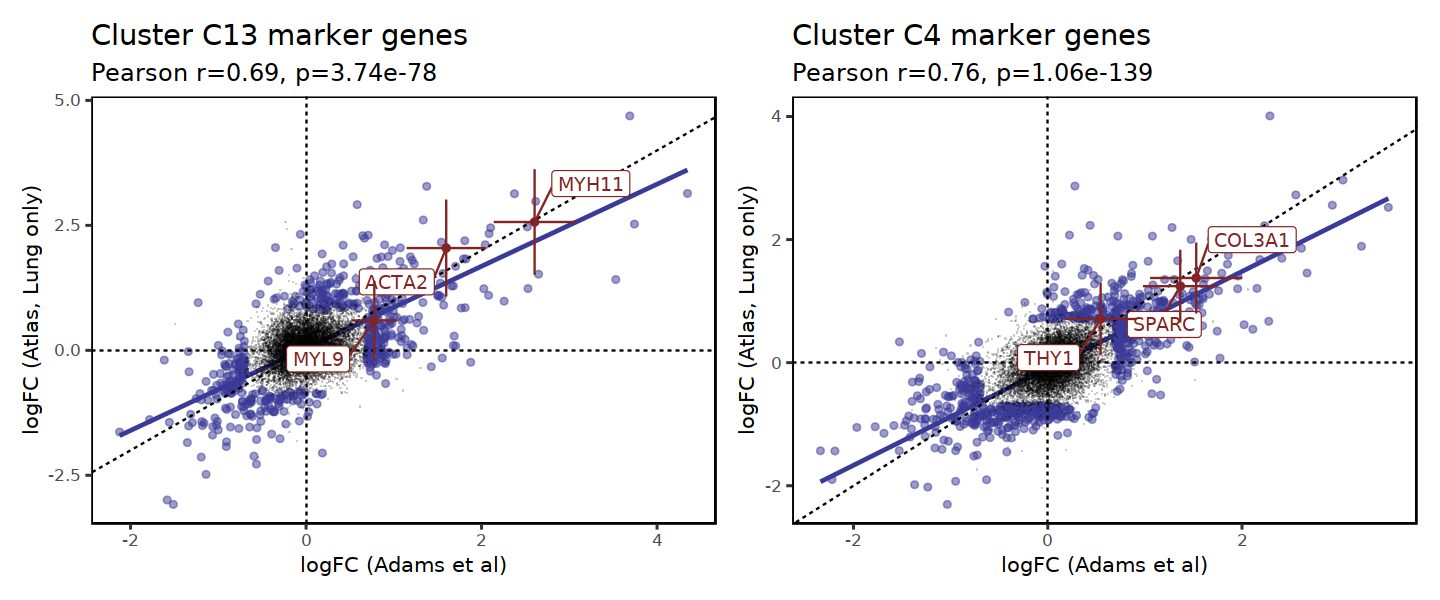

In [25]:
fig.size(5, 12)
p12 <- foo('13', c('MYH11', 'MYL9', 'ACTA2')) 
p13 <- foo('4', c('SPARC', 'COL3A1', 'THY1')) 
p12 | p13

In [26]:
plt_df %>% 
    subset(Cluster == '4') %>% 
#     subset(feature %in% c('MYH11', 'MYL9', 'ACTA2')) %>% 
    subset(feature %in% c('SPARC', 'COL3A1', 'THY1')) %>% 
#     dplyr::mutate(sigma_roche = 2 * sigma_roche) %>% 
#     dplyr::mutate(sigma_adams = 2 * sigma_adams) %>% 
    dplyr::select(feature, matches('^beta'), matches('^sigma'))

feature,beta_adams,beta_roche,sigma_adams,sigma_roche
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SPARC,1.3641994,1.2428569,0.1919274,0.2956946
COL3A1,1.5284963,1.3756519,0.2375596,0.2887907
THY1,0.5442917,0.7097452,0.1817941,0.2931198


# Panels

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



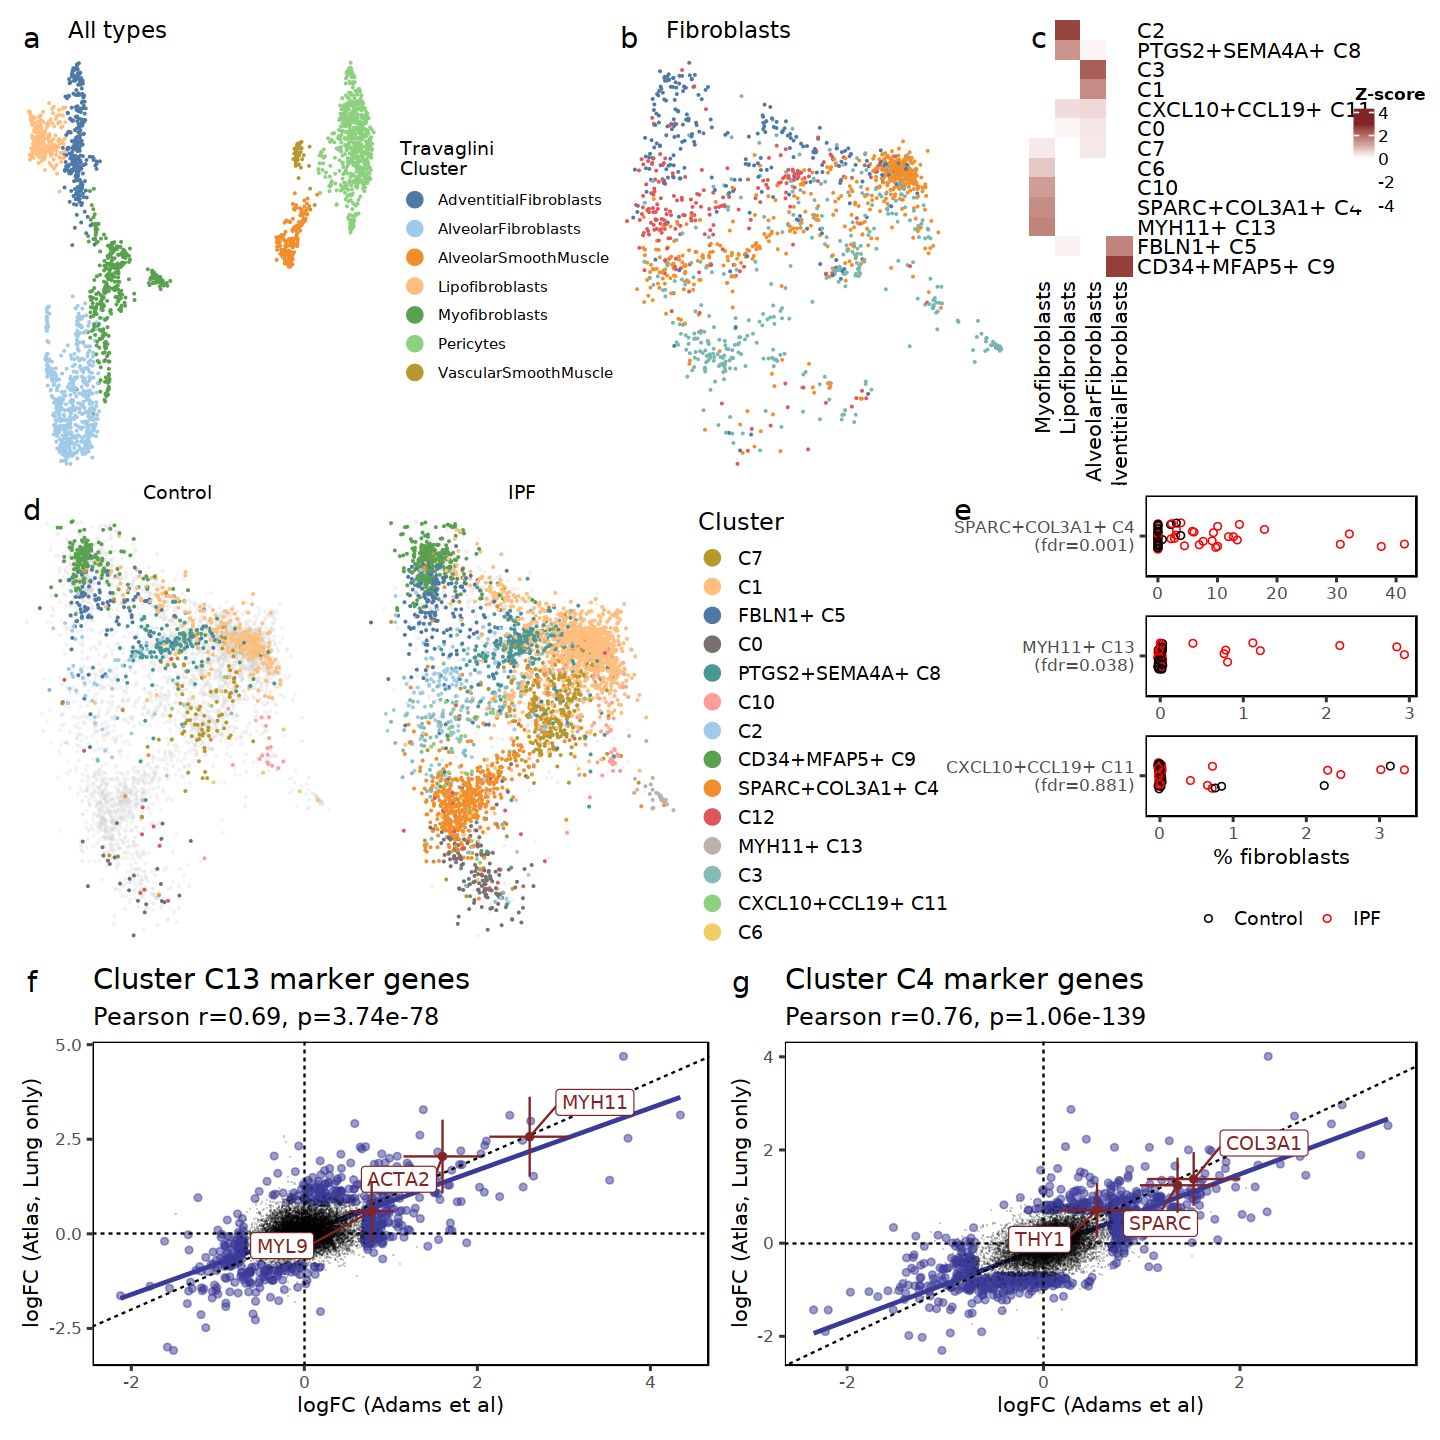

In [27]:
fig.size(12, 12)
main_figure <- (
#     (p4 | p5) + plot_layout(widths = c(3, 1))
#     (p4) / 
    (
        (wrap_elements(
            full = p5 + labs(title = 'All types') + theme(plot.title=element_text(hjust=.2))
        ) | wrap_elements(
            full = p6 + labs(title = 'Fibroblasts') + theme(plot.title=element_text(hjust=.2))
        ) | p7) + 
        plot_layout(widths = c(1.5, 1, 1))
    ) / 
#     (p8 | p9 | p10 | p11)
    (
        (wrap_elements(full = p8) | wrap_elements(full = p10)) + 
        plot_layout(widths = c(2, 1))
    ) / 
    (wrap_elements(full = p12) | wrap_elements(full = p13))
) + 
#     plot_layout(heights = c(3, 1)) + 
    plot_annotation(tag_levels = 'a')

main_figure


In [28]:
ggsave(
    filename = '../../manuscript/figures/Figure6.pdf', 
    plot = main_figure, 
    units = 'in', device = 'pdf', 
    height = 12, width = 12,
    useDingbats = FALSE
)


ggsave(
    filename = '../../manuscript/figures/Figure6.png', 
    plot = main_figure, 
    units = 'in', device = 'png', 
    height = 12, width = 12
)


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

